<a href="https://colab.research.google.com/github/kimchangwoo1011/2020--2-AI/blob/master/20160774-%EA%B9%80%EC%B0%BD%EC%9A%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.회귀 문제
회귀 문제 회귀는 가격이나 확률같이 연속된 값을 예측하는 것이 목적이다.

분류의 경우 여러개의 클래스 중에 하나의 클래스를 선택하는 것이다.

Auto MPG dataset을 사용하여 1970 후반 - 1980 초반의 자동차 연비를 예측하는 모델을 만든다.

In [1]:
!pip install -q seaborn                                  # 산점도 행렬을 그리기 위해 seaborn 패키지 코딩
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 1.0MB 13.1MB/s 
     |████████████████████████████████| 380.5MB 47kB/s 
     |████████████████████████████████| 4.3MB 57.3MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 501kB 61.9MB/s 


In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns                          #산점도 행렬을 그리기 위해서 사용하는 패키지

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0-rc1


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path                                             # 데이터셋을 다운로드

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',         #데이터 읽어오기
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()  # 결측치 drop, Horsepower가 누락된 6개 sample 삭제

In [9]:
#Origin의 값을 one-hot으로 표현 (1)
dataset['Origin'] = dataset['Origin'].map(lambda x: {1:'USA', 2:'Europe',3:'Japan'}.get(x))
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)                                                #데이터셋을 훈련 세트와 테스트 세트로 분할

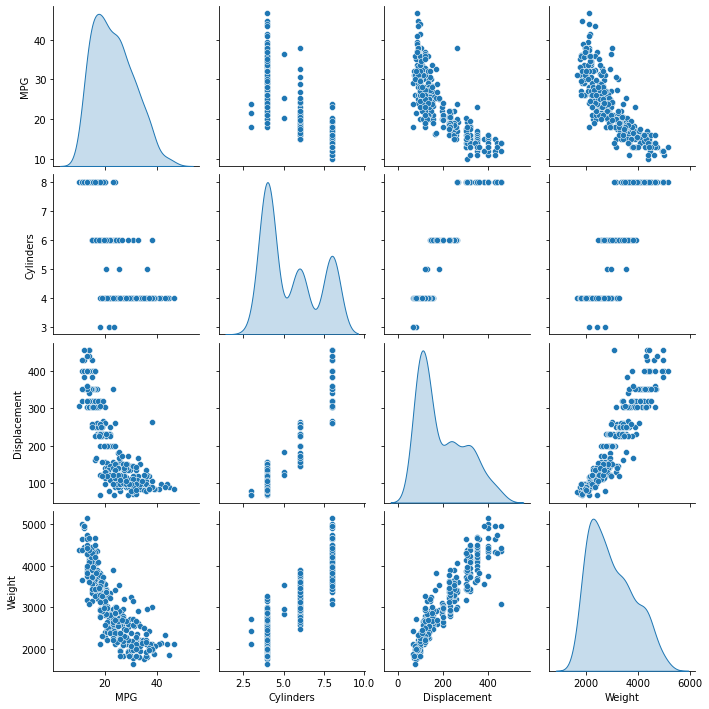

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")    #산점도 행렬 만들기
                                                                                                #diag_kind="kde"는 커널 밀도 히스토그램을 그린다는 의미.

In [12]:
train_stats = train_dataset.describe()                                          #통계확인
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [13]:
train_labels = train_dataset.pop('MPG')                                         # MPG feature drop, MPG를 타겟으로 사용하여 분리
test_labels = test_dataset.pop('MPG')

In [14]:
def norm(x):                                                                     #(값-평균)/표준편차
    return (x - train_stats['mean'])/train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [15]:
   def build_model():                                                           #모델을 구성
                                                                                #두 개의 완전 연결(densely connected) 은닉층으로 Sequential 모델만들고
                                                                                #출력 층은 하나의 연속적인 값을 반환 두 번째 모델을 만들기 쉽도록 build_model 함수로 모델 구성 단계 
    model = keras.Sequential([
                              layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [16]:
model = build_model()                                                            #모델 만들기

In [17]:
model.summary()                                                                  #모델 확인

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________


In [18]:
example_batch = normed_train_data[:10]  # sample batch size = 10                 ##만들어진 모델 세부 확인
print(normed_train_data[:10])
example_result = model.predict(example_batch)
example_result  # predicted MPG

     Cylinders  Displacement  Horsepower  ...    Europe     Japan       USA
146  -0.869348     -1.009459   -0.784052  ... -0.465148 -0.495225  0.774676
282  -0.869348     -0.530218   -0.442811  ... -0.465148 -0.495225  0.774676
69    1.483887      1.482595    1.447140  ... -0.465148 -0.495225  0.774676
378  -0.869348     -0.865687   -1.099044  ... -0.465148 -0.495225  0.774676
331  -0.869348     -0.942365   -0.994047  ... -0.465148  2.012852 -1.286751
257   0.307270      0.351586   -0.390312  ... -0.465148 -0.495225  0.774676
310  -0.869348     -1.019044   -1.177792  ... -0.465148  2.012852 -1.286751
328  -0.869348     -0.472709   -0.994047  ...  2.143005 -0.495225 -1.286751
125   0.307270      0.025702   -0.259066  ... -0.465148 -0.495225  0.774676
108  -0.869348     -0.942365   -0.442811  ... -0.465148  2.012852 -1.286751

[10 rows x 9 columns]


array([[-0.30457065],
       [-0.02687333],
       [-0.29305488],
       [-0.10734151],
       [-0.15110947],
       [-0.04293326],
       [-0.17205743],
       [ 0.0758317 ],
       [-0.0749917 ],
       [-0.44344294]], dtype=float32)

In [19]:
EPOCHS = 1000                                                                   #모델을 1,000번의 에포크(epoch) 동안 훈련
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose = 0,
    callbacks=[tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:571.5266,  mae:22.7030,  mse:571.5266,  val_loss:552.3877,  val_mae:22.2949,  val_mse:552.3877,  
....................................................................................................
Epoch: 100, loss:5.7399,  mae:1.6720,  mse:5.7399,  val_loss:8.5748,  val_mae:2.2323,  val_mse:8.5748,  
....................................................................................................
Epoch: 200, loss:5.4452,  mae:1.6766,  mse:5.4452,  val_loss:8.8311,  val_mae:2.4073,  val_mse:8.8311,  
....................................................................................................
Epoch: 300, loss:4.6187,  mae:1.5001,  mse:4.6187,  val_loss:8.4165,  val_mae:2.2255,  val_mse:8.4165,  
....................................................................................................
Epoch: 400, loss:4.1665,  mae:1.4049,  mse:4.1665,  val_loss:8.3503,  val_mae:2.1795,  val_mse:8.3503,  
..............................................................

In [20]:
hist = pd.DataFrame(history.history)                                            # history에 저장된 통계치를 사용해서 훈련 과정을 시각화
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.076696,0.952736,2.076696,11.515481,2.694460,11.515481,995
996,1.727012,0.861824,1.727012,11.534073,2.703667,11.534073,996
997,2.436038,1.145932,2.436038,11.500555,2.763710,11.500555,997
998,1.726923,0.876842,1.726923,11.821701,2.767282,11.821702,998
999,2.285773,0.999012,2.285773,10.315923,2.454092,10.315924,999


Text(0, 0.5, 'MAE [MPG]')

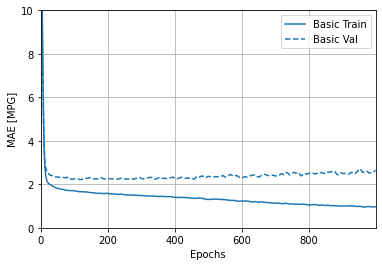

In [21]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic':history}, metric='mae')
plt.ylim([0,10])
plt.ylabel('MAE [MPG]') #Mean Absolute Error

Text(0, 0.5, 'MSE [MPG^2]')

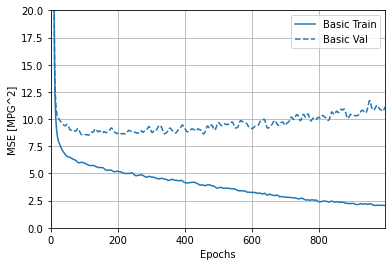

In [22]:
plotter.plot({'Basic':history}, metric = 'mse')
plt.ylim([0,20])
plt.ylabel('MSE [MPG^2]')

In [23]:
model = build_model()
#patience는 성능향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_history = model.fit(normed_train_data, train_labels,
                          epochs=EPOCHS, validation_split=0.2, verbose=0,
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:553.9470,  mae:22.2464,  mse:553.9470,  val_loss:511.6438,  val_mae:21.2461,  val_mse:511.6438,  
..................................

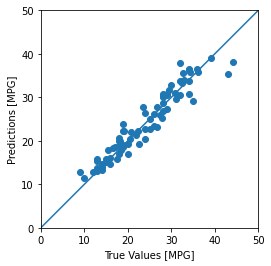

In [24]:
test_predictions = model.predict(normed_test_data).flatten()                    # 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

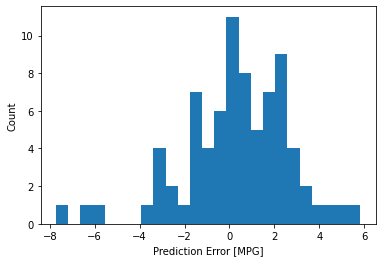

In [25]:
error = test_predictions - test_labels                                          
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

#분류 문제: Iris 붓꽃 분류
개요와 목적

다양한 Iris 꽃들의 품종들을 분류하고 구분하려고 하는 목적을갖고 진행하였는데

먼저 setosa, versicolor, virginica 종으로 분류한 붓꽃의 측정 데이터를 이용하여 앞에서 채집한 붓꽃이 어떤 품종인지 구분하려고 사용되고 image.png
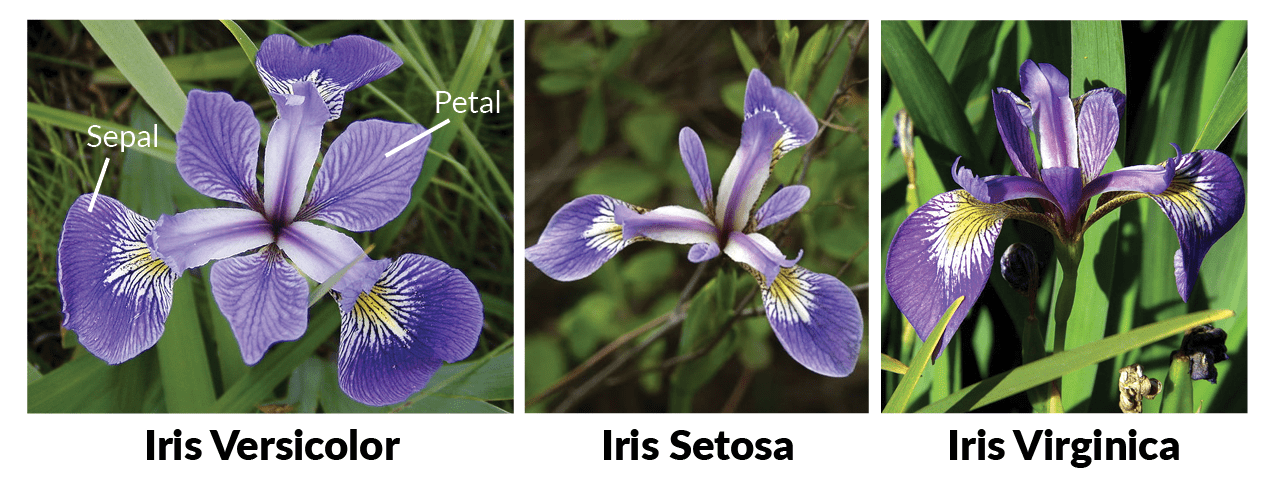
최종 목적으로는 어떤 품종인지 구분해놓은 측정 데이터를 이용해 새로 채집한 붓꽃의 품종을 예측하는 머신러닝 모델을 만드는것

In [26]:
from sklearn.datasets import load_iris            # 패키지 불러오기


iris = load_iris()                      # 붓꽃 데이터 세트를 로딩한다.
                        
iris_data = iris.data                  # iris.data는 Iris 데이터 세트에서 피처(feature)만으로 된 데이터를 numpy로 가지고 있다. 


iris_label = iris.target                # iris.target은 붓꽃 데이터 세트에서 NumPy
print('iris target값:', iris_label[[0, 50, 100]])
print('iris target명:', iris.target_names)

iris target값: [0 1 2]
iris target명: ['setosa' 'versicolor' 'virginica']


In [27]:
import pandas as pd                  # 수집한 데이터들을 표로 만들어 확인


iris_df = pd.DataFrame(data = iris_data, columns = iris.feature_names)
iris_df['label'] = iris.target
print(iris_df.head(3).to_markdown())


|    |   sepal length (cm) |   sepal width (cm) |   petal length (cm) |   petal width (cm) |   label |
|---:|--------------------:|-------------------:|--------------------:|-------------------:|--------:|
|  0 |                 5.1 |                3.5 |                 1.4 |                0.2 |       0 |
|  1 |                 4.9 |                3   |                 1.4 |                0.2 |       0 |
|  2 |                 4.7 |                3.2 |                 1.3 |                0.2 |       0 |


In [28]:
temp_data = iris_df.copy()                          #데이터 프레임을 만들어 확인

replace_fct = {0: 'setosa', 1: 'versicolor', 2: "virginica"}
temp_data.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"] 
temp_data['species'] = temp_data['species'].map(replace_fct)

temp_data.head(3).to_markdown()

'|    |   sepal_length |   sepal_width |   petal_length |   petal_width | species   |\n|---:|---------------:|--------------:|---------------:|--------------:|:----------|\n|  0 |            5.1 |           3.5 |            1.4 |           0.2 | setosa    |\n|  1 |            4.9 |           3   |            1.4 |           0.2 | setosa    |\n|  2 |            4.7 |           3.2 |            1.3 |           0.2 | setosa    |'

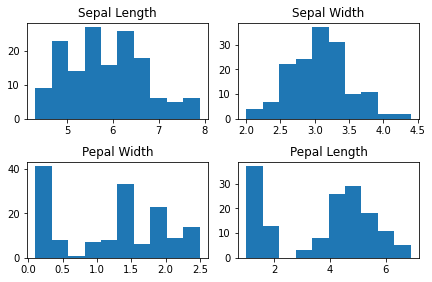

In [29]:
import matplotlib.pyplot as plt

n_bins = 10
fig, axs = plt.subplots(2, 2)                          # 데이터 시각화를 위해 레이아웃 작성한다. 
axs[0, 0].hist(temp_data['sepal_length'], bins = n_bins);
axs[0, 0].set_title('Sepal Length');
axs[0, 1].hist(temp_data['sepal_width'], bins = n_bins);
axs[0, 1].set_title('Sepal Width');
axs[1, 0].hist(temp_data['petal_width'], bins = n_bins);
axs[1, 0].set_title('Pepal Width');
axs[1, 1].hist(temp_data['petal_length'], bins = n_bins);
axs[1, 1].set_title('Pepal Length');

fig.tight_layout(pad=1.0);

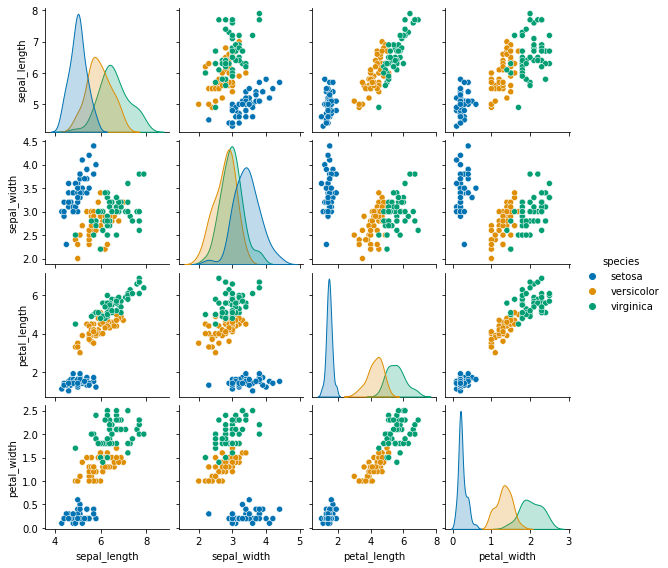

In [30]:
import seaborn as sns                             # 산점도를구현하여 각 수치형 데이터의 크기에 따라 종의 구분
sns.pairplot(temp_data, hue="species", height = 2, palette = 'colorblind');

In [31]:
from sklearn.model_selection import train_test_split                   #데이터 훈련과 데이터 테스트 분류
X_train, X_test, y_train, y_test = train_test_split(iris_data,         # 독립변수 
                                                    iris_label,        # 종속변수 
                                                    test_size = 0.2, 
                                                    random_state = 1)

In [32]:
from sklearn.tree import DecisionTreeClassifier                       #모델 형성


dt_clf = DecisionTreeClassifier(random_state=11)                     # DecisionTreeClassifier 객체 생성


dt_clf.fit(X_train, y_train)                                         # 학습 수행

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=11, splitter='best')

In [33]:
from sklearn.metrics import accuracy_score                  #모델 예측 및 테스트
pred = dt_clf.predict(X_test)                               # 학습이 완료된 DecisionTreeClassifier 객체에서 테스트 데이터 세트로 예측 수행
print('The accuracy of the Decision Tree is: {:.3f}'.format(accuracy_score(pred,y_test)))  #정확도 96.67% 

The accuracy of the Decision Tree is: 0.967


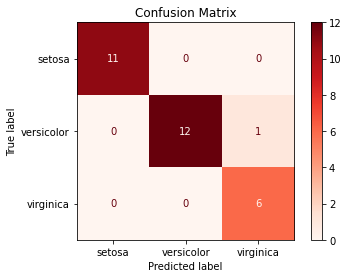

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree          #시각화를 주어진 데이터를 가지고 작성한다.
from sklearn.metrics import plot_confusion_matrix

labels = ['setosa', 'versicolor', 'virginica']
disp = plot_confusion_matrix(dt_clf, 
                             X_test, y_test, 
                             display_labels=labels, 
                             cmap=plt.cm.Reds, 
                             normalize=None)
disp.ax_.set_title('Confusion Matrix');

# CNN 문제 : CIFA-10 분류
개요와 목적

CIFAR-10은 이미지 분류 작업을위한 벤치 마크 데이터 세트 중 하나이며
목적으로는 CNN을 통해 이 CIFAR-10가지 종류의 이미지들을 적절하게 분류해 내는 것과 데이터 세트를 통해 이미지 분류에 대한 다양한 접근 방식을 탐색 할 수있었습니다.
 
데이터 세트를 학습하고 Google Colab 노트북에서 예측을 수행하며 문제와 결과를 출력하려고 하는 목적 


In [ ]:
import numpy as np                             # 사용할 라이브러리 불러오기


from keras.utils import np_utils               # 숫자 -> One-hot Vector 를 위한 라이브러리

from keras.datasets import cifar10             # cifar-10 Dataset을 가져오기 위한 라이브러리

from keras.models import Sequential            # 순차적인 모델을 만들기 위한 Sequential 함수

from keras.layers import Dense, Activation     # 필요한 층들을 가지고 있는 layers 라이브러리
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten

                                                
from google.colab.patches import cv2_imshow    # Google Colab에서 이미지를 보기 위한 cv2_imshow 함수

170500096/170498071 [==============================] - 4s 0us/step
x_train : (50000, 32, 32, 3)
y_train : (50000, 1)
x_test : (10000, 32, 32, 3)
y_test : (10000, 1)


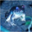

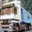

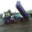

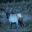

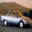

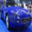

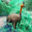

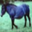

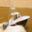

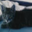

In [ ]:
                                                           
(x_train, y_train), (x_test, y_test) = cifar10.load_data()  # cifar-10 Dataset 가져오기
print('x_train :', np.shape(x_train))
print('y_train :', np.shape(y_train))
print('x_test :', np.shape(x_test))
print('y_test :', np.shape(y_test))

for i in range(10):                                         # Training Dataset의 이미지 10개
  cv2_imshow(x_train[i])

In [ ]:
x_train = x_train.astype('float32') / 255.0      # Loss의 스케일 조정을 위해 0 ~ 255 -> 0 ~ 1 범위로 
x_test = x_test.astype('float32') / 255.0
                                                 # Test Dataset을 Validation Set
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print('y_train :', np.shape(y_train))

y_train : (50000, 10)


In [ ]:
width = 32                                                      # 모델 구성하기
height = 32                                        # 높이, 너비, 채널(RGB) 설정
channel = 3
model = Sequential(name='CIFAR10_CNN')            # 순차적 모델을 만들기 위한 Sequential() 함수

# filters : Kernel 그룹의 갯수 / kernel_size : Kernel 크기
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', 
                 input_shape=(width, height, channel)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
# pool_size : MaxPooling 의 Window size
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())                                        # N차원 배열을 1차원
                                
model.add(Dense(10, activation='softmax'))                              # 출력층 
model.summary()

Model: "CIFAR10_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         

In [ ]:
# 모델 학습과정 설정하기
# loss : 목적 함수
# categorical_crossentropy : 분류가 2개 이상인 CEE
# optimizer : 학습 방법, SGD를 사용합니다.
# metrics : 학습 도중 화면에 어떤 값을 띄울까를 결정합니다.
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

hist = model.fit(x_train, y_train,                 # 모델 학습시키기                                              
              epochs=30,                           # hist는 Epoch 당 학습 결과
              batch_size=32,
              validation_data=(x_test, y_test))

Epoch 1/30
1563/1563 [==============================] - 8s 5ms/step - loss: 2.0605 - accuracy: 0.2453 - val_loss: 1.8024 - val_accuracy: 0.3505
Epoch 2/30
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5601 - accuracy: 0.4452 - val_loss: 1.4231 - val_accuracy: 0.4975
Epoch 3/30
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3738 - accuracy: 0.5125 - val_loss: 1.3627 - val_accuracy: 0.5184
Epoch 4/30
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2429 - accuracy: 0.5594 - val_loss: 1.2587 - val_accuracy: 0.5594
Epoch 5/30
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1328 - accuracy: 0.6018 - val_loss: 1.1524 - val_accuracy: 0.5944
Epoch 6/30
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0400 - accuracy: 0.6354 - val_loss: 1.1463 - val_accuracy: 0.5981
Epoch 7/30
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9522 - accuracy: 0.6675 - val_loss: 1.1003 - val_accuracy:

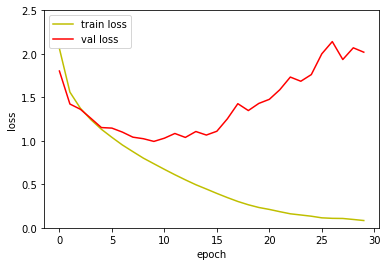

In [ ]:
import matplotlib.pyplot as plt     # 그래프를 그리기 위한 matplotlib 라이브러리

plt.plot(hist.history['loss'], 'y', label='train loss')
plt.plot(hist.history['val_loss'], 'r', label='val loss')

plt.ylim([0.0, 2.5])               # y축 범위 설정
plt.xlabel('epoch')                # 각 축의 이름 정하기
plt.ylabel('loss') 
plt.legend(loc='upper left')      # 각 그래프의 설명 위치 설정 후 표시
plt.show()

In [ ]:
loss_and_acc = model.evaluate(x_test, y_test, batch_size=32)  #모델 평가
print('Test set Loss and Accuracy')
print(loss_and_acc)

313/313 [==============================] - 1s 3ms/step - loss: 2.0190 - accuracy: 0.6779
Test set Loss and Accuracy
[2.019035577774048, 0.6779000163078308]


예측: 고양이 / 정답: 고양이


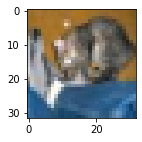

예측: 배 / 정답: 배


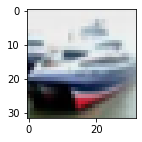

예측: 비행기 / 정답: 배


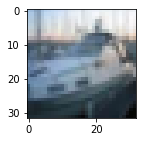

예측: 배 / 정답: 비행기


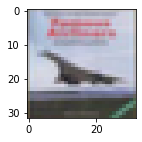

예측: 사슴 / 정답: 개구리


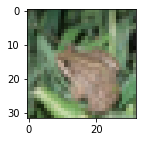

예측: 개구리 / 정답: 개구리


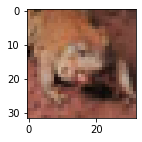

예측: 자동차 / 정답: 자동차


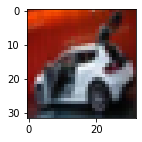

예측: 개구리 / 정답: 개구리


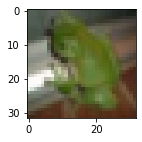

예측: 고양이 / 정답: 고양이


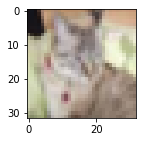

예측: 자동차 / 정답: 자동차


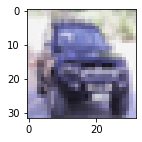

In [ ]:
labels = ['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭']  #모델 사용하기
                                                                                           # 이미지 리스트

plt.rcParams["figure.figsize"] = (2,2)                                 # 출력 그림의 크기를 결정                   

for i in range(10): 
  output = model.predict(x_test[i].reshape(1,width, height, channel))  # 모델 사용
   
  plt.imshow(x_test[i].reshape(width, height, channel))                 # 이미지 출력 
  # np.argmax()가 labels의 인덱스가 되어 labels 배열에 있는 문자열을 출력
  print('예측: ' + labels[np.argmax(output)] + ' / 정답: ' + labels[np.argmax(y_test[i])])
  plt.show()